## Importing Necessary Modules

In [ ]:
!pip install optuna

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

import optuna   # Automated hyperparameter optimization framework
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
import json
import joblib

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Importing Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle

# Create the Kaggle directory and copy Kaggle API key
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

# Set appropriate permissions for the Kaggle API key
! chmod 600 ~/.kaggle/kaggle.json

# Download and unzip the Zomato Bangalore Restaurants dataset from Kaggle
!kaggle datasets download -d himanshupoddar/zomato-bangalore-restaurants
!unzip zomato-bangalore-restaurants.zip

In [6]:
data = pd.read_csv("/content/zomato.csv")

## Exploratory Data Analysis

In [7]:
data.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [8]:
data.shape

(51717, 17)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 51

In [10]:
100*data.isnull().sum()/len(data)

url                             0.000000
address                         0.000000
name                            0.000000
online_order                    0.000000
book_table                      0.000000
rate                           15.033741
votes                           0.000000
phone                           2.335789
location                        0.040606
rest_type                       0.438927
dish_liked                     54.291626
cuisines                        0.087012
approx_cost(for two people)     0.669026
reviews_list                    0.000000
menu_item                       0.000000
listed_in(type)                 0.000000
listed_in(city)                 0.000000
dtype: float64

In [11]:
data.columns

Index(['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'phone', 'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost(for two people)', 'reviews_list', 'menu_item',
       'listed_in(type)', 'listed_in(city)'],
      dtype='object')

In [12]:
df = data.copy()

In [13]:
df = df.drop([ 'url','phone', 'location','reviews_list','rest_type'], axis=1)

In [14]:
df = df[-df["rate"].isna()]   # New restaurant without ratings
df = df[df["votes"]>=50]      # Dropping restaurants with fewer than 50 votes
df.drop("votes",axis=1,inplace=True) # Omitting vote features for future predictions

In [15]:
# Handling NaN values
df['approx_cost(for two people)'] = df['approx_cost(for two people)'].str.replace(",","").astype(float)
col = ["listed_in(city)","listed_in(type)"]
ser = df.groupby(col)['approx_cost(for two people)'].transform('median')
df['approx_cost(for two people)'] = df['approx_cost(for two people)'].fillna(ser)

df["dish_liked"].replace(np.nan, "", inplace=True)
df.dropna(inplace=True)

In [16]:
# Rating Category
def r_category(rating):
    if rating>=4.0:
        return "Excellent"
    elif rating>=3.0:
        return "Good"
    elif rating>=2.5:
        return "Average"
    else:
        return "Poor"

# Price Category
def p_category(price):
    if price<=100.0:
        return "Cheap"
    elif price<=250.0:
        return "Resonable"
    elif price<=500.0:
        return "Affordable"
    else:
        return "Expensive"

In [17]:
# Deriving features
df['Cost_Per_Person'] = df['approx_cost(for two people)']/2
df["rate"] = df["rate"].str[0:3].astype(float)
df["Category"] = df["rate"].apply(r_category)
df["Price_Category"] = df["Cost_Per_Person"].apply(p_category)

df["Menu"]=df["menu_item"].map(lambda x: "No" if x=='[]' else "Yes")   # Menu availability status

df['dish_liked']=df['dish_liked'].map(lambda x:0 if x=="" else len(x.split(", ")))  # Customer's liked dishes count

df['No_of_Varieties']=df['cuisines'].apply(lambda x:len(x.split(", ")))  # Restaurant's variety count

In [18]:
change={'name':'Name',
        'address':'Address',
        'online_order':"Delivery",
        'book_table':"Booking",
        'rate':"Rating",
        'dish_liked':"No_of_Best_Sellers",
        'cuisines':"Cuisines",
        'approx_cost(for two people)':"Average_Cost",
        'listed_in(type)':"Type",
        'listed_in(city)':"City"}

df.rename(columns=change,inplace=True)

In [19]:
df.reset_index(drop=True,inplace=True)

In [20]:
# Categorizing Cuisines
def Cuisine_category(string):
    l = string.split(", ")

    if "Afghan" in l:
        l=list(map(lambda x: x.replace('Afghan', 'Afghani'), l))

    if "Bubble Tea" in l:
        l=list(map(lambda x: x.replace('Bubble Tea', 'Beverages'), l))

    if "Coffee" in l:
        l=list(map(lambda x: x.replace('Coffee', 'Beverages'), l))

    if "Cafe" in l:
        l=list(map(lambda x: x.replace('Cafe', 'Beverages'), l))

    if "Tea" in l:
        l=list(map(lambda x: x.replace('Tea', 'Beverages'), l))

    if "Bubble Beverages" in l:
        l=list(map(lambda x: x.replace('Bubble Beverages', 'Beverages'), l))

    if "Ice Cream" in l:
        l=list(map(lambda x: x.replace('Ice Cream', 'Desserts'), l))

    if "Mithai" in l:
        l=list(map(lambda x: x.replace('Mithai', 'Desserts'), l))

    if "Bar Food" in l:
        l=list(map(lambda x: x.replace('Bar Food', 'Fast Food'), l))

    if "Burger" in l:
        l=list(map(lambda x: x.replace('Burger', 'Fast Food'), l))

    if "Finger Food" in l:
        l=list(map(lambda x: x.replace('Finger Food', 'Fast Food'), l))

    if "Momos" in l:
        l=list(map(lambda x: x.replace('Momos', 'Fast Food'), l))

    if "Rolls" in l:
        l=list(map(lambda x: x.replace('Rolls', 'Fast Food'), l))

    if "Wraps" in l:
        l=list(map(lambda x: x.replace('Wraps', 'Fast Food'), l))

    if "Street Food" in l:
        l=list(map(lambda x: x.replace('Street Food', 'Fast Food'), l))

    if "Juices" in l:
        l=list(map(lambda x: x.replace('Juices', 'Healthy Food'), l))

    if "Salad" in l:
        l=list(map(lambda x: x.replace('Salad', 'Healthy Food'), l))

    if "Sandwich" in l:
        l=list(map(lambda x: x.replace('Sandwich', 'Healthy Food'), l))

    if "Grill" in l:
        l=list(map(lambda x: x.replace('Grill', 'BBQ'), l))

    if "Steak" in l:
        l=list(map(lambda x: x.replace('Steak', 'BBQ'), l))

    if "Sushi" in l:
        l=list(map(lambda x: x.replace('Sushi', 'Japanese'), l))

    if "Tex-Mex" in l:
        l=list(map(lambda x: x.replace('Tex-Mex', 'Mexican'), l))

    if "Roast Chicken" in l:
        l=list(map(lambda x: x.replace('Roast Chicken', 'Chinese'), l))

    if "Charcoal Chicken" in l:
        l=list(map(lambda x: x.replace('Charcoal Chicken', 'Chinese'), l))

    if "Pizza" in l:
        l=list(map(lambda x: x.replace('Pizza', 'Italian'), l))

    if "Biryani" in l:
        l=list(map(lambda x: x.replace('Biryani', 'South Indian'), l))

    if "Kebab" in l:
        l=list(map(lambda x: x.replace('Kebab', 'North Indian'), l))

    return ", ".join(set(l))

df["Cuisines"] = df["Cuisines"].apply(Cuisine_category)

In [21]:
df = df[['Name', 'Address', 'Menu', 'Delivery', 'Booking', 'No_of_Best_Sellers', 'No_of_Varieties', 'Cuisines',
     'Cost_Per_Person', 'Type', 'City', 'Rating', 'Category', 'Price_Category']]
df.head()

,Name,Address,Menu,Delivery,Booking,No_of_Best_Sellers,No_of_Varieties,Cuisines,Cost_Per_Person,Type,City,Rating,Category,Price_Category
0,Jalsa,"942, 21st Main Road, 2nd Stage, Banashankari, ...",No,Yes,Yes,7,3,"North Indian, Chinese, Mughlai",400.0,Buffet,Banashankari,4.1,Excellent,Affordable
1,Spice Elephant,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",No,Yes,No,7,3,"Thai, North Indian, Chinese",400.0,Buffet,Banashankari,4.1,Excellent,Affordable
2,San Churro Cafe,"1112, Next to KIMS Medical College, 17th Cross...",No,Yes,No,7,3,"Beverages, Mexican, Italian",400.0,Buffet,Banashankari,3.8,Good,Affordable
3,Addhuri Udupi Bhojana,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",No,No,No,1,2,"North Indian, South Indian",150.0,Buffet,Banashankari,3.7,Good,Resonable
4,Grand Village,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",No,No,No,2,2,"North Indian, Rajasthani",300.0,Buffet,Banashankari,3.8,Good,Affordable


## Data Preprocessing

In [22]:
multi_label = df["Cuisines"].str.split(", ")

In [23]:
mlb = MultiLabelBinarizer()
inter_data = mlb.fit_transform(multi_label)
multi_label_df = pd.DataFrame(inter_data,columns=mlb.classes_)

In [24]:
data = df[['Name','Menu','Delivery', 'Booking','Type', 'City','No_of_Best_Sellers', 'No_of_Varieties',
         'Cost_Per_Person', 'Rating','Category','Price_Category']]
dataframe = pd.concat([data,multi_label_df],axis=1)
dataframe.head()

,Name,Menu,Delivery,Booking,Type,City,No_of_Best_Sellers,No_of_Varieties,Cost_Per_Person,Rating,...,South American,South Indian,Spanish,Sri Lankan,Tamil,Thai,Tibetan,Turkish,Vegan,Vietnamese
0,Jalsa,No,Yes,Yes,Buffet,Banashankari,7,3,400.0,4.1,...,0,0,0,0,0,0,0,0,0,0
1,Spice Elephant,No,Yes,No,Buffet,Banashankari,7,3,400.0,4.1,...,0,0,0,0,0,1,0,0,0,0
2,San Churro Cafe,No,Yes,No,Buffet,Banashankari,7,3,400.0,3.8,...,0,0,0,0,0,0,0,0,0,0
3,Addhuri Udupi Bhojana,No,No,No,Buffet,Banashankari,1,2,150.0,3.7,...,0,1,0,0,0,0,0,0,0,0
4,Grand Village,No,No,No,Buffet,Banashankari,2,2,300.0,3.8,...,0,0,0,0,0,0,0,0,0,0


In [25]:
dataframe.to_csv("display.csv", index=False)

In [26]:
d = df[['Name', 'Address', 'Menu', 'Delivery', 'Booking', 'Type', 'City', 'No_of_Best_Sellers', 'No_of_Varieties',
      'Cost_Per_Person', 'Rating', 'Category', 'Price_Category']]
dataframe = pd.concat([d, multi_label_df], axis=1)

In [27]:
dataframe.duplicated(subset=['Name','Address']).sum()

19279

In [28]:
dataframe.drop_duplicates(subset=['Name','Address'],inplace=True)

In [29]:
len(dataframe)

4872

In [30]:
categoric = dataframe[['Delivery', 'Booking', 'City']]
numeric = dataframe[['No_of_Best_Sellers', 'No_of_Varieties', 'Cost_Per_Person', 'Rating']]

In [31]:
encoder = OneHotEncoder()
one_hot_df = pd.DataFrame(encoder.fit_transform(categoric).toarray(), index=list(dataframe.index))

In [32]:
df_inter = pd.concat([numeric,multi_label_df.iloc[list(dataframe.index),:],one_hot_df], axis=1)
df_inter.reset_index(drop=True, inplace=True)
df_inter.head()

,No_of_Best_Sellers,No_of_Varieties,Cost_Per_Person,Rating,Afghani,African,American,Andhra,Arabian,Asian,...,24,25,26,27,28,29,30,31,32,33
0,7,3,400.0,4.1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7,3,400.0,4.1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,3,400.0,3.8,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2,150.0,3.7,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,2,300.0,3.8,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
X = df_inter.drop("Rating",axis=1).values
y = df_inter["Rating"].values

## Data Visualisation and Insigths

In [34]:
idf = pd.read_csv("display.csv")
idf.head()

,Name,Menu,Delivery,Booking,Type,City,No_of_Best_Sellers,No_of_Varieties,Cost_Per_Person,Rating,...,South American,South Indian,Spanish,Sri Lankan,Tamil,Thai,Tibetan,Turkish,Vegan,Vietnamese
0,Jalsa,No,Yes,Yes,Buffet,Banashankari,7,3,400.0,4.1,...,0,0,0,0,0,0,0,0,0,0
1,Spice Elephant,No,Yes,No,Buffet,Banashankari,7,3,400.0,4.1,...,0,0,0,0,0,1,0,0,0,0
2,San Churro Cafe,No,Yes,No,Buffet,Banashankari,7,3,400.0,3.8,...,0,0,0,0,0,0,0,0,0,0
3,Addhuri Udupi Bhojana,No,No,No,Buffet,Banashankari,1,2,150.0,3.7,...,0,1,0,0,0,0,0,0,0,0
4,Grand Village,No,No,No,Buffet,Banashankari,2,2,300.0,3.8,...,0,0,0,0,0,0,0,0,0,0


In [35]:
col = mlb.classes_

In [ ]:
df = idf["Delivery"].value_counts()
fig = px.pie(values=df.values, names=df.index, title='Online Delivery')
py.iplot(fig)

In [ ]:
df = idf["Booking"].value_counts()
fig = px.pie(values=df.values, names=df.index, title='Table Booking')
py.iplot(fig)

In [ ]:
df = idf["Category"].value_counts()
fig = px.pie(values=df.values, names=df.index, title='Category')
py.iplot(fig)

In [ ]:
df = idf["Price_Category"].value_counts()
fig = px.pie(values=df.values, names=df.index, title='Price Category')
py.iplot(fig)

In [40]:
inter = idf.groupby("City")[["Cost_Per_Person"]].mean()
sol=inter.sort_values(by="Cost_Per_Person",ascending=False).head()
sol.style.background_gradient(cmap="YlOrRd",high=0.5)

,Cost_Per_Person
City,
Lavelle Road,515.641026
Church Street,513.009165
Residency Road,507.262045
Brigade Road,502.995868
MG Road,500.569185


In [41]:
inter = idf.groupby("City")[["Cost_Per_Person"]].mean()
sol=inter.sort_values(by="Cost_Per_Person").head()
sol.style.background_gradient(cmap="YlOrRd",high=0.5)

,Cost_Per_Person
City,
Banashankari,248.263889
Basavanagudi,279.953198
Bannerghatta Road,285.983333
JP Nagar,292.497156
Jayanagar,295.845656


In [ ]:
fig = px.scatter(idf, x="Cost_Per_Person", y="Rating")
py.iplot(fig)

In [ ]:
inter = idf.groupby(['No_of_Best_Sellers', 'No_of_Varieties'])[["Menu"]].count()
inter.rename(columns={"Menu":"Count"},inplace=True)
inter.reset_index(inplace=True)

fig = px.bar(inter,x="No_of_Varieties",y="Count",color="No_of_Best_Sellers",barmode="group")
py.iplot(fig)

In [44]:
city = "Banashankari"

inter = idf[idf["City"]=="Banashankari"]

d1 = inter.groupby("Type")["Type"].count().sort_values(ascending=False)
d2 = inter.groupby("Type")["Cost_Per_Person"].agg(['min','median','max'])


sol = pd.concat([d1,d2],axis=1)
cols = ['No','Min_cpp','Median_cpp','Max_cpp']  # cpp = cost per person
sol.columns = cols
sol.style.background_gradient(cmap="YlOrRd",high=0.5)

,No,Min_cpp,Median_cpp,Max_cpp
Type,,,,
Delivery,242,50.000000,225.000000,750.000000
Dine-out,144,50.000000,200.000000,650.000000
Cafes,18,100.000000,287.500000,400.000000
Desserts,17,75.000000,200.000000,400.000000
Buffet,6,150.000000,350.000000,400.000000
Drinks & nightlife,5,400.000000,550.000000,650.000000


In [ ]:
City = "Banashankari"
Type = "Delivery"

inter = idf[(idf["City"]==City)&(idf["Type"]==Type)]['Cost_Per_Person']
fig = px.histogram(inter, x='Cost_Per_Person')
py.iplot(fig)

In [ ]:
city = "Sarjapur Road"

inter = idf[idf["City"]=="Sarjapur Road"]
ser = inter.groupby(["City"])[col].sum()
index = ser.columns
val=ser.values.T.flatten()
series=pd.Series(val,index)
ii=series.sort_values(ascending=False).head()
fig = px.bar(df,x=ii.index,y=ii.values)
py.iplot(fig)

In [47]:
City = "Old Airport Road"

ser = idf.groupby(["City","Type"])[col].sum()
dicton = {}

for i in range(len(ser)):
    index = ser.columns
    val = ser.iloc[i].values.T.flatten()
    series = pd.Series(val,index)
    vall = list(series.sort_values(ascending=False).head().index)
    dicton[ser.index[i]] = vall

sol = pd.DataFrame(dicton,index=['1st','2nd','3rd','4th','5th'])
frame = sol.T
frame.loc[City]

,1st,2nd,3rd,4th,5th
Buffet,North Indian,Continental,Chinese,Italian,Mughlai
Cafes,Beverages,Desserts,Fast Food,Italian,Continental
Delivery,North Indian,Fast Food,Chinese,South Indian,Beverages
Desserts,Desserts,Beverages,Fast Food,Bakery,Italian
Dine-out,North Indian,Chinese,Fast Food,South Indian,Continental
Drinks & nightlife,Continental,North Indian,Chinese,Fast Food,Italian
Pubs and bars,Continental,North Indian,Chinese,Fast Food,American


In [ ]:
city = "Sarjapur Road"

cols = idf["Type"].unique()
df = pd.DataFrame()

inter = idf[idf["City"]=="Sarjapur Road"]
inter = inter.groupby("Type")[col].sum().T

for i in cols:
    ser = inter[i].sort_values(ascending=False).head()
    df_inter = pd.DataFrame(ser)
    df_inter.reset_index(inplace=True)
    df_inter.rename(columns={i:"Count","index":"Cuisine"},inplace=True)
    df_inter["Type"] = i
    df = pd.concat([df,df_inter],axis=0)

fig = px.bar(df,x="Type",y="Count",color="Cuisine")
py.iplot(fig)

In [ ]:
City = "BTM"
sel = ["North Indian","South Indian","Chinese","Fast Food","Italian"]
df = pd.DataFrame()
order = {'Price_Category':['Cheap','Resonable','Affordable', 'Expensive']}

for i in sel:
    inter = idf[idf[i]==1]
    inter = inter.groupby(["Price_Category"])[["Menu"]].count()
    inter = inter.reset_index()
    inter.rename(columns={"Menu":"Count"},inplace=True)
    inter["Cuisine_Type"] = i
    df = pd.concat([df,inter],axis=0)


fig = px.bar(x=df["Cuisine_Type"], y=df["Count"],color=df["Price_Category"],barmode="group",
             category_orders={"Price_Category": ["Cheap", "Resonable", "Affordable", "Expensive"]})
py.iplot(fig)

In [ ]:
City = "BTM"
sel = ["North Indian","South Indian","Chinese","Fast Food","Italian"]
df = pd.DataFrame()

for i in sel:
    inter = idf[idf[i]==1]
    inter = inter.groupby(["Category"])[["Menu"]].count()
    inter = inter.reset_index()
    inter.rename(columns={"Menu":"Count"},inplace=True)
    inter["Cuisine_Type"] = i
    df = pd.concat([df,inter],axis=0)

fig = px.bar(x=df["Cuisine_Type"], y=df["Count"], color=df["Category"],barmode="group")
py.iplot(fig)

## Modelling

In [51]:
def get_models():
    models,names = [],[]

    models.append(RandomForestRegressor())
    names.append("RandomForestRegressor")

    models.append(XGBRegressor())
    names.append("XGBRegressor")

    models.append(LGBMRegressor())
    names.append("LGBMRegressor")

    return models,names

In [52]:
models,names = get_models()
scores = []

for i in range(len(models)):
    score = cross_val_score(models[i],X,y,cv=5,scoring='neg_mean_squared_error',n_jobs=-1)
    scores.append(score)

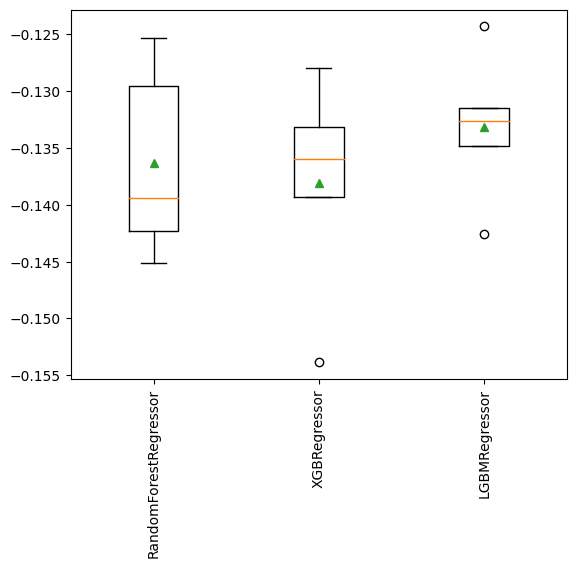

In [53]:
plt.boxplot(scores,labels=names,showmeans=True)
plt.xticks(rotation="vertical");

## Hyperparameter Optimization

In [54]:
def objective(trial):

    params = { "n_estimators": trial.suggest_int("n_estimators", 100, 400),
             "max_depth": trial.suggest_int("max_depth", 4, 10),
             "learning_rate":trial.suggest_float("learning_rate", 0.01, 1.0,log=True),
             "subsample":trial.suggest_float("subsample", 0.5, 1.0),
             "reg_alpha": trial.suggest_float("reg_alpha",0.0,1.0)}

    model = LGBMRegressor(random_state=1,**params)
    score = cross_val_score(model,X,y,cv=5,scoring='neg_mean_squared_error',n_jobs=-1)
    return score.mean()

In [55]:
study = optuna.create_study(study_name="Hyperparameter optimization",direction="maximize",
                            sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=50,show_progress_bar=True)

[I 2023-12-15 17:23:46,415] A new study created in memory with name: Hyperparameter optimization


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-12-15 17:23:47,578] Trial 0 finished with value: -0.14173724246772512 and parameters: {'n_estimators': 212, 'max_depth': 10, 'learning_rate': 0.29106359131330695, 'subsample': 0.7993292420985183, 'reg_alpha': 0.15601864044243652}. Best is trial 0 with value: -0.14173724246772512.
[I 2023-12-15 17:23:48,356] Trial 1 finished with value: -0.13752749157659583 and parameters: {'n_estimators': 146, 'max_depth': 4, 'learning_rate': 0.5399484409787431, 'subsample': 0.8005575058716043, 'reg_alpha': 0.7080725777960455}. Best is trial 1 with value: -0.13752749157659583.
[I 2023-12-15 17:23:49,064] Trial 2 finished with value: -0.1429947550773923 and parameters: {'n_estimators': 106, 'max_depth': 10, 'learning_rate': 0.46225890010208287, 'subsample': 0.6061695553391381, 'reg_alpha': 0.18182496720710062}. Best is trial 1 with value: -0.13752749157659583.
[I 2023-12-15 17:23:49,961] Trial 3 finished with value: -0.13269043077111345 and parameters: {'n_estimators': 155, 'max_depth': 6, 'lear

In [56]:
print(f"Best value: {study.best_trial.value}")
print(f"Best hyperparameters:\n {json.dumps(study.best_trial.params, indent=2)}")

Best value: -0.13204849042718833
Best hyperparameters:
 {
  "n_estimators": 164,
  "max_depth": 9,
  "learning_rate": 0.0666650693064964,
  "subsample": 0.6500845376671763,
  "reg_alpha": 0.35376058521080156
}


In [ ]:
plot_optimization_history(study)

In [ ]:
plot_parallel_coordinate(study)

In [ ]:
plot_param_importances(study)

## Training Model and Dumping

In [60]:
model = LGBMRegressor(**study.best_trial.params)
model.fit(X,y)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 182
[LightGBM] [Info] Number of data points in the train set: 4872, number of used features: 63
[LightGBM] [Info] Start training from score 3.815722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

LGBMRegressor(learning_rate=0.0666650693064964, max_depth=9, n_estimators=164,
              reg_alpha=0.35376058521080156, subsample=0.6500845376671763)

In [61]:
joblib.dump(model,'model.pkl')
joblib.dump(mlb,'mlb.pkl')
joblib.dump(encoder,'encoder.pkl')

['encoder.pkl']